In [251]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [252]:
#stocks = ["MMM", "HOG", "LUV", "KO", "PJP"]
stocks = ["GILD","VITL","MSFT"] 
start_date = "2021-09-27"
end_date = "2023-06-06"

data = yf.download(stocks, start=start_date, end=end_date)['Close']
returns = data.pct_change().dropna()

#risk_free_rate = pd.read_csv("C:\\Users\\migue\\OneDrive\\Desktop\\Risk Management\\Risk Free Rate.csv")
#Rf=risk_free_rate['RF'].mean() 
#using the risk free rate from Ken French's Database and then averaging it out across the time horizon
Rf=0   #for simplicity can assume 0 or use .007 which is the avg

expected_returns = returns.mean() * 252
excess_returns = expected_returns-Rf
stdev = returns.std() * np.sqrt(252)
variance = stdev ** 2

cov_matrix = returns.cov() * 252
corr_matrix = returns.corr()

print("\nQuestion A:")
print(pd.DataFrame({"E(R)": expected_returns, "Excess Returns": excess_returns, "St. Dev": stdev, "Variance": variance}))
#if I just printed the stuff it would look ugly so I make a dataframe and fill it, then print it.
print("\nVar-Covar Matrix:")
print(cov_matrix)

print("\nCorrelation Matrix:")
print(corr_matrix)

sharpe_ratios = (expected_returns - Rf) / stdev
print("\nSharpe Ratio of The Stocks:")
print(sharpe_ratios)

[*********************100%***********************]  3 of 3 completed


Question A:
            E(R)  Excess Returns   St. Dev  Variance
Ticker                                              
GILD    0.123040        0.123040  0.230789  0.053264
MSFT    0.140191        0.140191  0.322697  0.104133
VITL   -0.009218       -0.009218  0.536766  0.288118

Var-Covar Matrix:
Ticker      GILD      MSFT      VITL
Ticker                              
GILD    0.053264  0.017205  0.016807
MSFT    0.017205  0.104133  0.042851
VITL    0.016807  0.042851  0.288118

Correlation Matrix:
Ticker      GILD      MSFT      VITL
Ticker                              
GILD    1.000000  0.231024  0.135671
MSFT    0.231024  1.000000  0.247387
VITL    0.135671  0.247387  1.000000

Sharpe Ratio of The Stocks:
Ticker
GILD    0.533126
MSFT    0.434436
VITL   -0.017174
dtype: float64


In [253]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    port_return = np.dot(weights, mean_returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return port_return, port_volatility

def min_variance(weights):
    return portfolio_performance(weights, expected_returns, cov_matrix)[1]

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})#sum of all weights should always = 1
bounds = [(0.00001, 1) for _ in range(len(stocks))]  # minimum weight of .00001 and maximum of 1
initial_weights = np.array([1/len(stocks)] * len(stocks))

min_var_result = minimize(min_variance, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints) 
#minimize the variance based on the constraints above
min_var_weights = min_var_result.x

def neg_sharpe_ratio(weights):
    ret, vol = portfolio_performance(weights, expected_returns, cov_matrix)
    return -((ret - Rf) / vol)

max_sharpe_result = minimize(neg_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
#in the function we are making a negative sharpe ratio and then minimizing. basically maximing the positive one
max_sharpe_weights = max_sharpe_result.x

print("\nMinimum Variance Portfolio Weights:")
print(pd.DataFrame(min_var_weights, index=stocks, columns=["Weight"]))

print("\nMax Sharpe Ratio Portfolio Weights:")
print(pd.DataFrame(max_sharpe_weights, index=stocks, columns=["Weight"]))

num_portfolios = 10000
portfolio_returns = []
portfolio_volatilities = []

for _ in range(num_portfolios):
    weights = np.random.dirichlet(np.ones(len(stocks)), size=1)[0]#generate random portfolio weights
    ret, vol = portfolio_performance(weights, expected_returns, cov_matrix) #calculate performance
    portfolio_returns.append(ret) #then store the performance values so we can graph it
    portfolio_volatilities.append(vol)

portfolio_returns = np.array(portfolio_returns)
portfolio_volatilities = np.array(portfolio_volatilities)



Minimum Variance Portfolio Weights:
        Weight
GILD  0.673164
VITL  0.260090
MSFT  0.066746

Max Sharpe Ratio Portfolio Weights:
       Weight
GILD  0.66023
VITL  0.33976
MSFT  0.00001


In [254]:
min_var_returns = expected_returns*min_var_weights   
print("Mininum Variance Portfolio Expected Return:",min_var_returns.sum())
max_sharpe_returns= expected_returns*max_sharpe_weights
print("Maximum Sharpe Portfolio Expected Return:",max_sharpe_returns.sum())
#calculate the returns for each portfolio and then print them

Mininum Variance Portfolio Expected Return: 0.1186729331752891
Maximum Sharpe Portfolio Expected Return: 0.1288657529572955


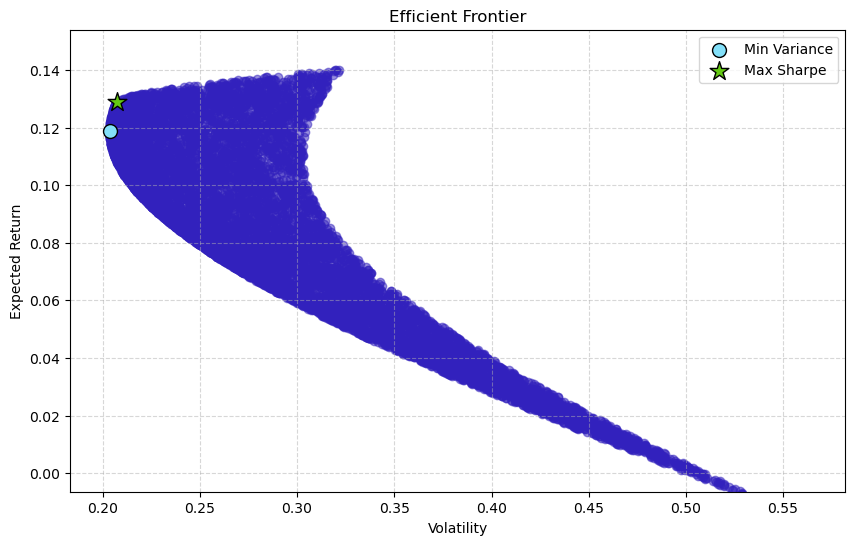

In [255]:
plt.figure(figsize=(10, 6))
plt.scatter(portfolio_volatilities, portfolio_returns, c='#3221bd', marker='o', alpha=0.5, zorder=1)

min_var_return, min_var_vol = portfolio_performance(min_var_weights, expected_returns, cov_matrix)
max_sharpe_return, max_sharpe_vol = portfolio_performance(max_sharpe_weights, expected_returns, cov_matrix)
plt.scatter(min_var_vol, min_var_return, color='#83e0f9', edgecolors='black', marker='o', s=100, label='Min Variance', zorder=3)
plt.scatter(max_sharpe_vol, max_sharpe_return, color='#64c913', edgecolors='black', marker='*', s=200, label='Max Sharpe', zorder=3)
#making the special portfolios look special

all_returns = np.append(portfolio_returns, [min_var_return, max_sharpe_return])
all_volatilities = np.append(portfolio_volatilities, [min_var_vol, max_sharpe_vol])
plt.xlim(min(all_volatilities) * 0.9, max(all_volatilities) * 1.1)
plt.ylim(min(all_returns) * 0.9, max(all_returns) * 1.1)
#expanding the graph, sort of unnecessary but I like all data to be in the graph. 

plt.xlabel('Volatility') , plt.ylabel('Expected Return'), plt.title('Efficient Frontier'), plt.legend(), plt.grid(True,linestyle='--',alpha=.5)
plt.show()
